<a href="https://colab.research.google.com/github/christian235711/covid/blob/main/preprocessing_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xlrd
from sklearn.model_selection import train_test_split


from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

- Le travail est divisé en plusieurs parties. Tout d'abord, la base de données est traitée afin d'éliminer les variables inutiles comme à l'étape du data exploraroty. Donc, nous récopions les lignes de code clés.

- Ensuite, les données sont divisées en deux échantillons (apprentissage et test)

- Le premier preprocessing (à l'aide de la fonction *preprocessing*) appliqué sur le dataset : encondent les variables qualitatives en 0 ou 1, éliminent les patients ayant au moins une caractéristique manquante (quatitatives et qualitatives) et divise chacune de deux échantillons en deux groupes (la varibles cible et les variables explicatives). 

- A la suite de cette étape, le premier modèle utilisé font appel aux arbres de décision (*DecisionTreeClassifier*) pour obtenir les premiers aperçus de la prédiction des données. Afin de mieux visualiser les resulats, les outils choisis sont la métrique f1-score, le matrice de confusion, le rapport de classification ainsi que les courbes d'apprentissages (issus de sklearn.metrics et sklearn.model_selection). Chacun de ses éléments sont dans la fonction *evaluation*. 
- Les resultats du premier modèle sont assez satisfaisants:
  - 96% des patients sains sont prédits correctement contre 17% des patients covid prédits correctement. 
  - 84% des patients prédits sains sont bien classés par opposition à 50% des patients prédits covid mal classés.
  - le score f1 montre également une disproportion des valeurs.

  - les courbes d'apprentissage nous montrent que le modèle est en overfitting.
- L'autre algorithme utilisé est le Random forest qui va lutter contre l'overfitting. 
- Il est également envisagé de travailler uniquement avec les variables sanguines, de créer une nouvelle variable *maladie* contenant les patients sains et les patients ayant au moins une maladie, de sélectionner les variables les plus importantes lors de la création d'un arbre de décision et d'utiliser des transformers. Certaines de ces idées sont prometteuses mais on ne les commentera pas car le but est de chercher un ensemble des données (création d'une nouvelle variable, élimination des valeurs manquantes) avec lesquels travailler lors de la modélisation et de répéter les modèles de machine learning les plus adaptés à la situation.









In [3]:
data_orig = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/covid/dataset_covid.xlsx")

data= data_orig.copy()

In [4]:
data.shape

(5644, 111)

In [5]:
# création d'une nouvelle base de données (reprise des caractéristiques sanguines et maladies virales que nous avons troouvé à l'étape su data exploratory)

# Eliminer les colonnes inutiles
data=data.loc[:, data.isna().sum()/data.shape[0] <.9 ] # ou data[  data.columns[data.isna().sum()/data.shape[0] < .9]  ]
data = data.drop(['Influenza A, rapid test', 'Influenza B, rapid test',],axis=1)

# création de deux groupes de variables
val = (data.isna().sum()/data.shape[0])*100
maladie_col = data.columns[(val > 76) & (val < 86)]
sang_col = data.columns[val > 86]
print("maladies : "+str(maladie_col))
print("sang : "+ str(sang_col))

maladies : Index(['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2'],
      dtype='object')
sang : Index(['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)'],
      dtype='object')


In [6]:
key_col = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [7]:
data = data[ key_col + list(sang_col) +  list(maladie_col)]
data

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# PREMIERE BASE DE DONNEES (data)
# train set et test set
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

In [9]:
train_set['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [10]:
test_set['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [11]:
def encodage(x):
  for i in x.select_dtypes('object') :
   x.loc[:,i] = x[i].map( {"positive":1, "negative":0, "detected":1, "not_detected":0} )
  #x.loc[:,"SARS-Cov-2 exam result"] = x["SARS-Cov-2 exam result"].map( {"positive":1, "negative":0} )
  return x


In [12]:
def feature_engineering(x):
  x['maladie']= x.loc[:, maladie_col].sum(axis=1) >=1
  x = x.drop(maladie_col, axis =1)
  return x

In [13]:
def imputation(x):
  return x.dropna(axis=0)

In [14]:
def preprocessing(x):
  x= encodage(x)
  x= imputation(x)

  y = x["SARS-Cov-2 exam result"] 
  W = x.drop("SARS-Cov-2 exam result", axis = 1)

  print(y.value_counts())
  return W, y

In [15]:
def preprocessing_feature_engineering(x):
  x= encodage(x)
  x= feature_engineering(x)
  x= imputation(x)

  y = x["SARS-Cov-2 exam result"] 
  W = x.drop("SARS-Cov-2 exam result", axis = 1)

  print(y.value_counts())
  return W, y

In [16]:
# Les quatres ensembles (X_train, y_train, X_test, y_test)
X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)


0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64
0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
# Modélisation

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif # SelectKbest pour sélectionner les k meilleures variables à l'aide d'une fonction et f_classif pour faire un test d'anova
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

# f1-score pour visualiser le rapport entre le précision et la sensibilité (recall). Ces sont des métriques qui nous permet de déterminer l'erreur de type I et l'erreur de type II.
# learning_curve pour voir si on est en underfitting ou overfitting

model_1 = DecisionTreeClassifier(random_state=0) # random_state pour fixer les valeurs aléatoires

model_2 = RandomForestClassifier(random_state =0)
model_3 = make_pipeline(SelectKBest(f_classif, k = 8), RandomForestClassifier(random_state=0)) # plusieurs modèles en fonction de k
model_4 = make_pipeline(PolynomialFeatures(2, include_bias = False) , SelectKBest(f_classif, k = 8), RandomForestClassifier(random_state=0))

model_5 = AdaBoostClassifier(random_state = 0)
model_6 = make_pipeline(SelectKBest(f_classif,k=8), AdaBoostClassifier(random_state=0) )

model_7 = BaggingClassifier(random_state =0)
model_8 = make_pipeline(SelectKBest(f_classif, k=8), BaggingClassifier(random_state=0) )

model_9 = GradientBoostingClassifier(random_state= 0)
model_10 = make_pipeline(SelectKBest(f_classif, k=8), GradientBoostingClassifier(random_state =0))

model_11 = SVC(random_state=0)
model_12 = make_pipeline(SelectKBest(f_classif, k=8), SVC(random_state=0))
model_13 = make_pipeline(SelectKBest(f_classif, k=8), StandardScaler() , SVC(random_state=0)) 

model_14 = KNeighborsClassifier()
model_15 = make_pipeline(SelectKBest(f_classif, k=8), KNeighborsClassifier() )
model_16 = make_pipeline(SelectKBest(f_classif, k=8), StandardScaler(), KNeighborsClassifier() )

model_17 = LogisticRegression(random_state =0)
model_18 = make_pipeline(SelectKBest(f_classif, k=8), LogisticRegression(random_state =0) )
model_19 = make_pipeline(SelectKBest(f_classif, k = 8), StandardScaler(), LogisticRegression(random_state=0) )

model_20 = XGBClassifier(random_state=0)
model_21 = make_pipeline(SelectKBest(f_classif, k=8), XGBClassifier(random_state = 0) )
model_22 = make_pipeline(SelectKBest(f_classif, k=8), StandardScaler(), XGBClassifier(random_state=0)) 


In [18]:
def evaluation(model, X_train, y_train, X_test, y_test):

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred)) 

  print(classification_report(y_train,model.predict(X_train) ))

  N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring = 'f1', train_sizes = np.linspace(0.1, 1, 10) )

  plt.figure(figsize = (10,6))
  plt.plot(N, train_score.mean(axis=1), label ="train_score")
  plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

  plt.legend()


[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296

                                                         0
Leukocytes                                        0.222302
Platelets                                         0.161302
Red blood Cells                                   0.140046
Influenza B                                       0.078269
Eosinophils                     

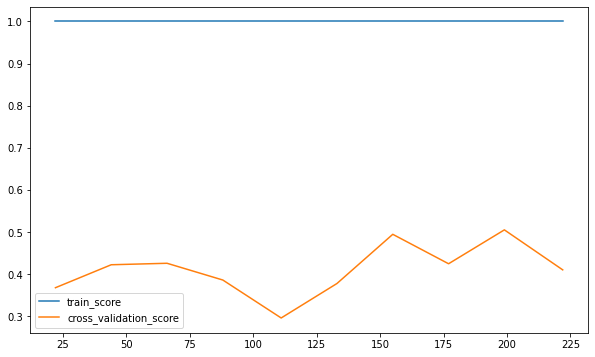

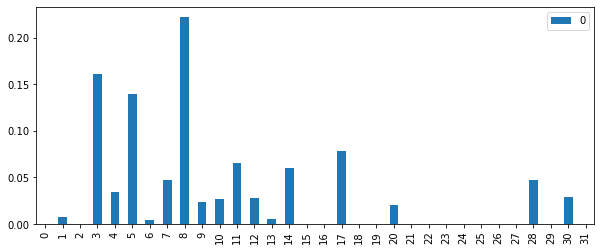

In [19]:
evaluation(model_1, X_train, y_train, X_test, y_test)
pd.DataFrame(model_1.feature_importances_).plot.bar(figsize=(10,4) )
print(pd.DataFrame(model_1.feature_importances_, index = X_train.columns).sort_values(0, ascending =False ) )


[[54  0]
 [11  1]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        54
           1       1.00      0.08      0.15        12

    accuracy                           0.83        66
   macro avg       0.92      0.54      0.53        66
weighted avg       0.86      0.83      0.77        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



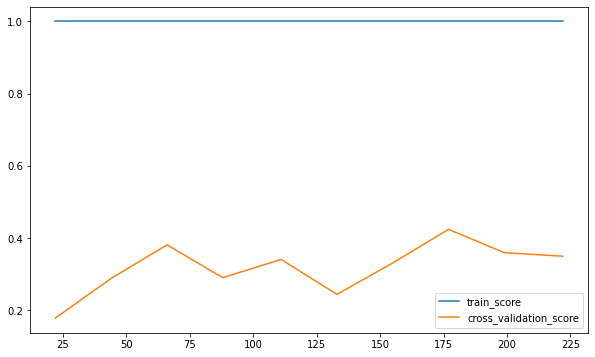

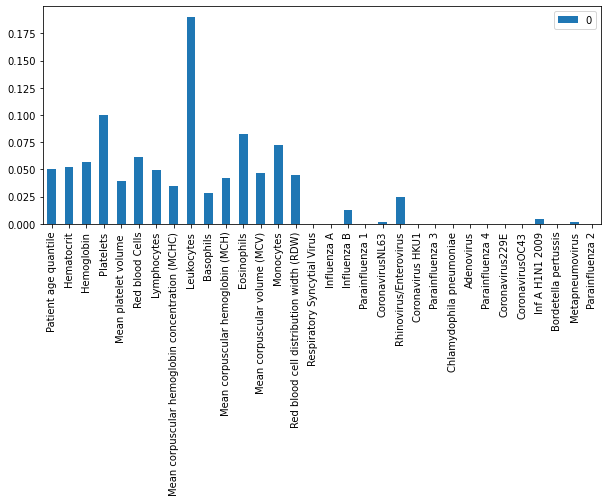

In [20]:
evaluation(model_2, X_train, y_train, X_test, y_test )
pd.DataFrame(model_2.feature_importances_, index = X_train.columns).plot.bar(figsize=(10,4) )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[54  0]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        54
           1       1.00      0.17      0.29        12

    accuracy                           0.85        66
   macro avg       0.92      0.58      0.60        66
weighted avg       0.87      0.85      0.80        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide

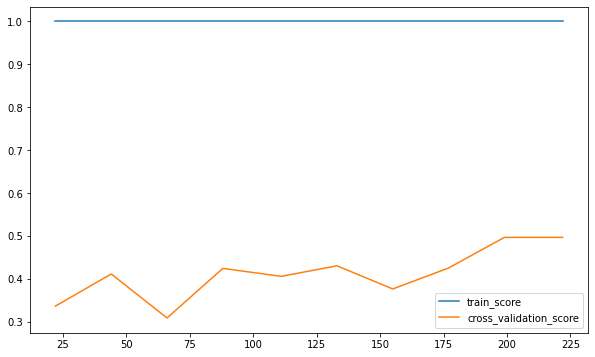

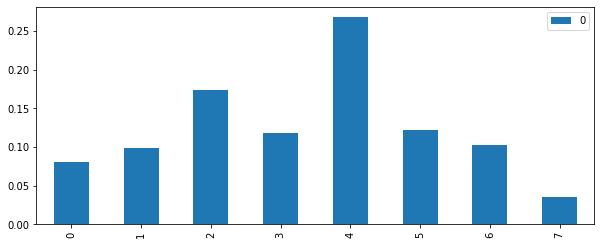

In [21]:
evaluation(model_3, X_train, y_train, X_test, y_test )
pd.DataFrame(model_3[1].feature_importances_).plot.bar(figsize=(10,4) )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 18  23  29  31  47  50  55  56  57  61  63  81  86  92  94 111 116 122
 124 140 145 151 153 168 173 179 181 195 200 206 208 221 226 232 234 246
 251 257 259 270 275 281 283 293 298 304 306 315 320 326 328 336 341 347
 349 356 361 367 369 375 380 386 388 393 398 404 406 408 409 410 411 413
 414 415 417 418 419 420 421 422 423 425 426 427 428 429 430 431 432 434
 435 437 438 439 441 442 444 445 446 447 448 449 450 452 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 470 471 473 474 475 476 477
 478 479 480 481 483 484 485 487 488 490 491 492 493 495 496 497 498 499
 500 501 502 503 504 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 525 526 527 528 529 530 531 533 534 535 536 537 538
 540 541 542 543 544 546 547 548 549 551 552 553 554 555 556 558 559] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature

[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 16  18  21  23  24  25  26  29  30  31  47  48  50  53  55  56  57  58
  61  62  63  79  81  84  86  87  88  89  92  93  94 109 111 114 116 117
 118 119 122 123 124 138 140 143 145 146 147 148 151 152 153 166 168 171
 173 174 175 176 179 180 181 193 195 198 200 201 202 203 206 207 208 219
 221 224 226 227 228 229 232 233 234 244 246 249 251 252 253 254 257 258
 259 268 270 273 275 276 277 278 281 282 283 291 293 296 298 299 300 301
 304 305 306 313 315 318 320 321 322 323 326 327 328 334 336 339 341 342
 343 344 347 348 349 354 356 359 361 362 363 364 367 368 369 373 375 378
 380 381 382 383 386 387 388 391 393 396 398 399 400 401 404 405 406 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 46

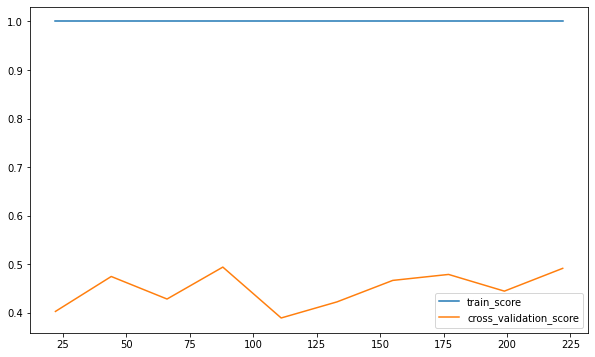

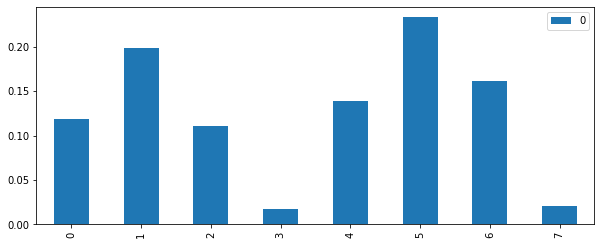

In [22]:
evaluation(model_4, X_train, y_train, X_test, y_test )
pd.DataFrame(model_4[2].feature_importances_).plot.bar(figsize=(10,4) )


[[51  3]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        54
           1       0.67      0.50      0.57        12

    accuracy                           0.86        66
   macro avg       0.78      0.72      0.75        66
weighted avg       0.85      0.86      0.86        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



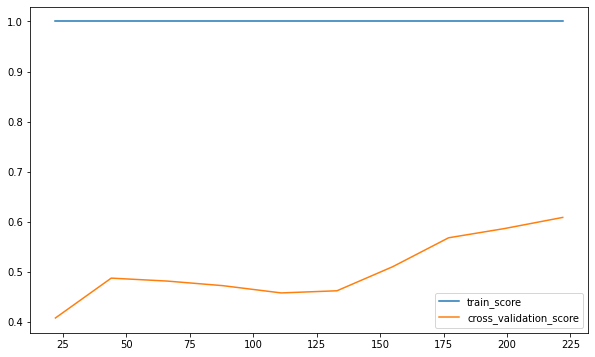

In [23]:
evaluation(model_5, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[51  3]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        54
           1       0.67      0.50      0.57        12

    accuracy                           0.86        66
   macro avg       0.78      0.72      0.75        66
weighted avg       0.85      0.86      0.86        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide

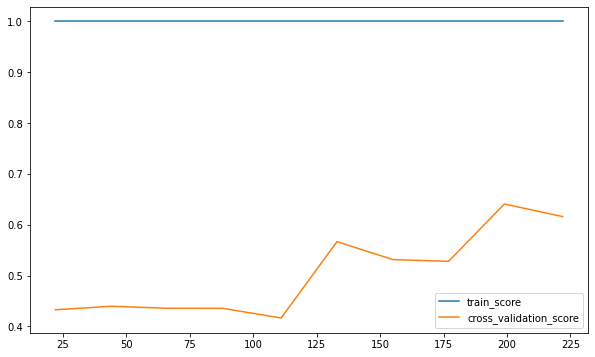

In [24]:
evaluation(model_6, X_train, y_train, X_test, y_test )


[[53  1]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        54
           1       0.67      0.17      0.27        12

    accuracy                           0.83        66
   macro avg       0.75      0.57      0.59        66
weighted avg       0.81      0.83      0.79        66

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       258
           1       0.97      0.92      0.95        38

    accuracy                           0.99       296
   macro avg       0.98      0.96      0.97       296
weighted avg       0.99      0.99      0.99       296



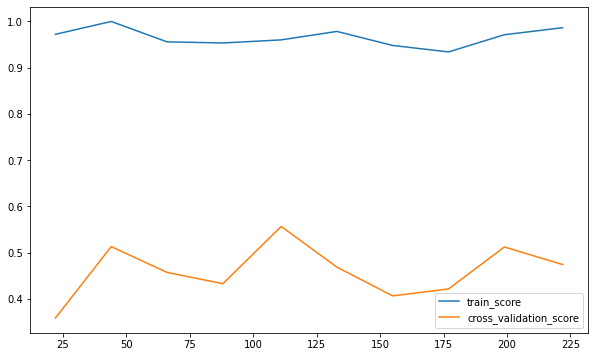

In [25]:
evaluation(model_7, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[54  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       258
           1       0.97      0.92      0.95        38

    accuracy                           0.99       296
   macro avg       0.98      0.96      0.97       296
weighted avg       0.99      0.99      0.99       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/p

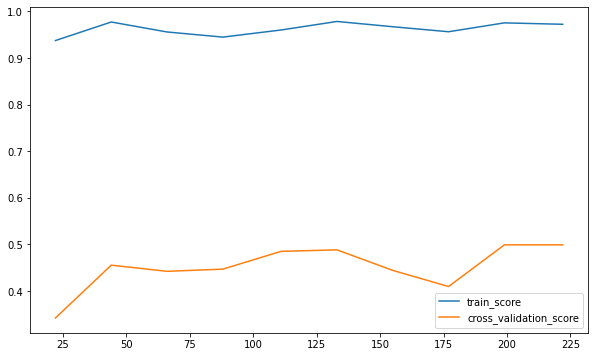

In [26]:
evaluation(model_8, X_train, y_train, X_test, y_test )


[[54  0]
 [ 7  5]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        54
           1       1.00      0.42      0.59        12

    accuracy                           0.89        66
   macro avg       0.94      0.71      0.76        66
weighted avg       0.91      0.89      0.88        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



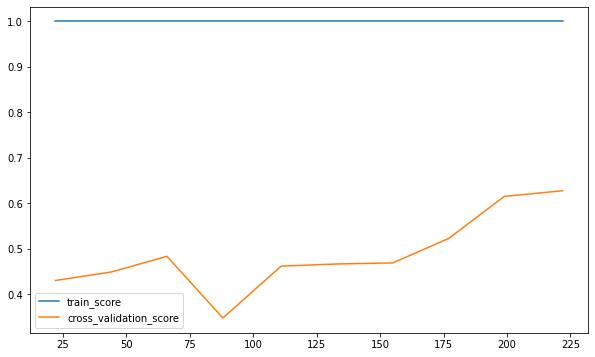

In [27]:
evaluation(model_9, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[54  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 23 25 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb /

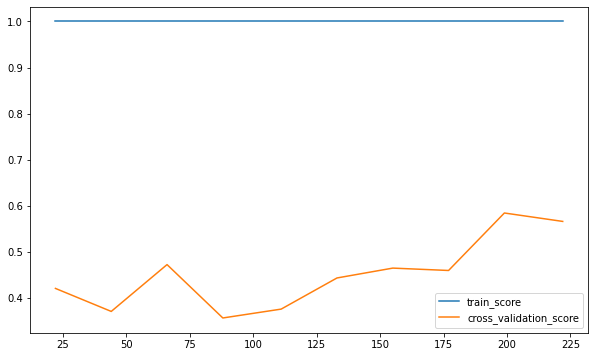

In [28]:
evaluation(model_10, X_train, y_train, X_test, y_test )


[[54  0]
 [12  0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        54
           1       0.00      0.00      0.00        12

    accuracy                           0.82        66
   macro avg       0.41      0.50      0.45        66
weighted avg       0.67      0.82      0.74        66

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       258
           1       0.00      0.00      0.00        38

    accuracy                           0.87       296
   macro avg       0.44      0.50      0.47       296
weighted avg       0.76      0.87      0.81       296



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


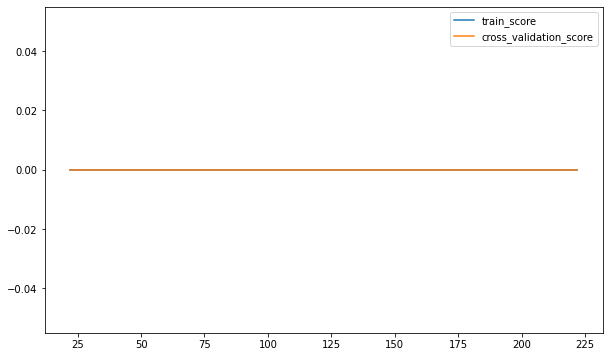

In [29]:
evaluation(model_11, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/fea

[[54  0]
 [12  0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        54
           1       0.00      0.00      0.00        12

    accuracy                           0.82        66
   macro avg       0.41      0.50      0.45        66
weighted avg       0.67      0.82      0.74        66

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       258
           1       0.00      0.00      0.00        38

    accuracy                           0.87       296
   macro avg       0.44      0.50      0.47       296
weighted avg       0.76      0.87      0.81       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 21 22 23 24 25 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid

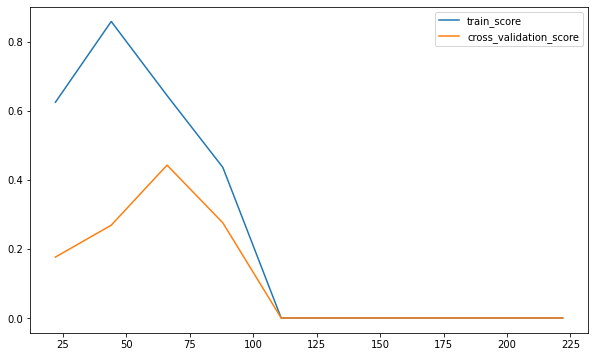

In [30]:
evaluation(model_12, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[52  2]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        54
           1       0.67      0.33      0.44        12

    accuracy                           0.85        66
   macro avg       0.77      0.65      0.68        66
weighted avg       0.83      0.85      0.83        66

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       258
           1       0.92      0.61      0.73        38

    accuracy                           0.94       296
   macro avg       0.93      0.80      0.85       296
weighted avg       0.94      0.94      0.94       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 24 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 24 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 24 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/

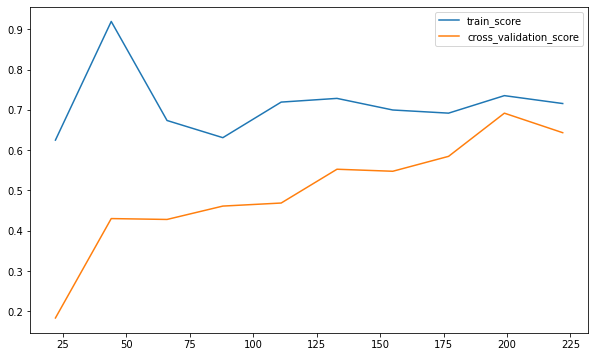

In [31]:
evaluation(model_13, X_train, y_train, X_test, y_test )


[[54  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       258
           1       0.72      0.61      0.66        38

    accuracy                           0.92       296
   macro avg       0.83      0.79      0.81       296
weighted avg       0.91      0.92      0.92       296



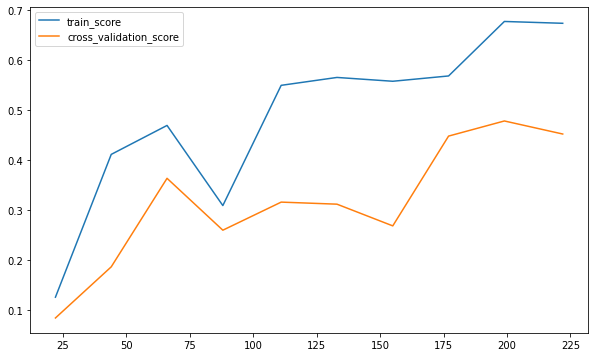

In [32]:
evaluation(model_14, X_train, y_train, X_test, y_test )

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[53  1]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        54
           1       0.80      0.33      0.47        12

    accuracy                           0.86        66
   macro avg       0.83      0.66      0.70        66
weighted avg       0.86      0.86      0.84        66

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       258
           1       0.81      0.58      0.68        38

    accuracy                           0.93       296
   macro avg       0.88      0.78      0.82       296
weighted avg       0.92      0.93      0.92       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 21 22 23 24 25 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 21 22 23 24 25 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value

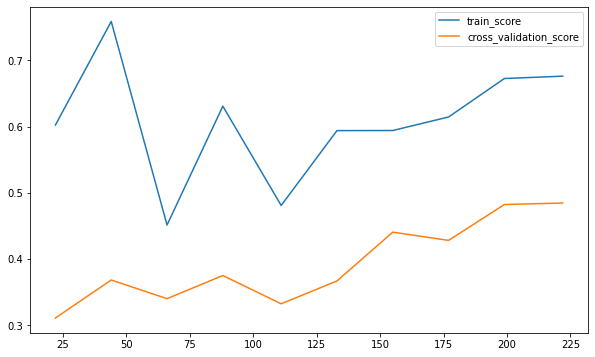

In [33]:
evaluation(model_15, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[49  5]
 [ 7  5]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        54
           1       0.50      0.42      0.45        12

    accuracy                           0.82        66
   macro avg       0.69      0.66      0.67        66
weighted avg       0.81      0.82      0.81        66

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       258
           1       0.88      0.74      0.80        38

    accuracy                           0.95       296
   macro avg       0.92      0.86      0.89       296
weighted avg       0.95      0.95      0.95       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 21 22 23 24 25 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid

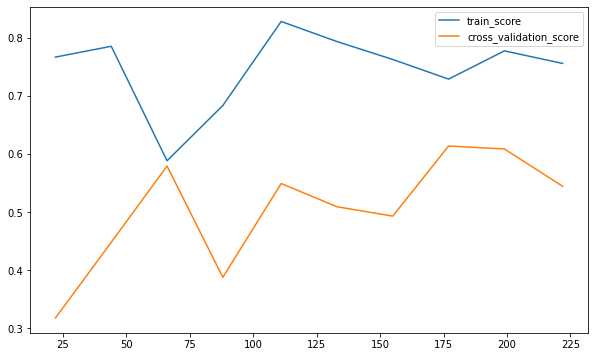

In [34]:
evaluation(model_16, X_train, y_train, X_test, y_test )


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[52  2]
 [ 7  5]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        54
           1       0.71      0.42      0.53        12

    accuracy                           0.86        66
   macro avg       0.80      0.69      0.72        66
weighted avg       0.85      0.86      0.85        66

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       258
           1       0.79      0.58      0.67        38

    accuracy                           0.93       296
   macro avg       0.86      0.78      0.81       296
weighted avg       0.92      0.93      0.92       296



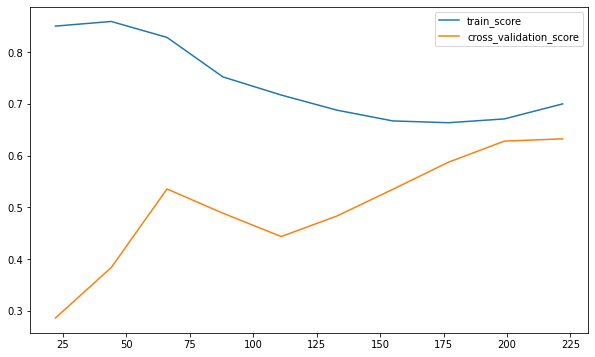

In [35]:
evaluation(model_17, X_train, y_train, X_test, y_test )

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[52  2]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        54
           1       0.67      0.33      0.44        12

    accuracy                           0.85        66
   macro avg       0.77      0.65      0.68        66
weighted avg       0.83      0.85      0.83        66

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       258
           1       0.80      0.53      0.63        38

    accuracy                           0.92       296
   macro avg       0.87      0.75      0.80       296
weighted avg       0.92      0.92      0.92       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 19 21 22 23 24 25 26 27 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

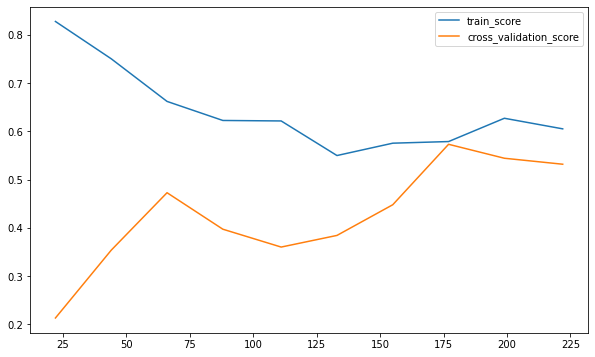

In [36]:
evaluation(model_18, X_train, y_train, X_test, y_test )

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[52  2]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        54
           1       0.67      0.33      0.44        12

    accuracy                           0.85        66
   macro avg       0.77      0.65      0.68        66
weighted avg       0.83      0.85      0.83        66

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       258
           1       0.77      0.53      0.62        38

    accuracy                           0.92       296
   macro avg       0.85      0.75      0.79       296
weighted avg       0.91      0.92      0.91       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 21 22 23 24 25 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 24 25 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 24 26 27 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_

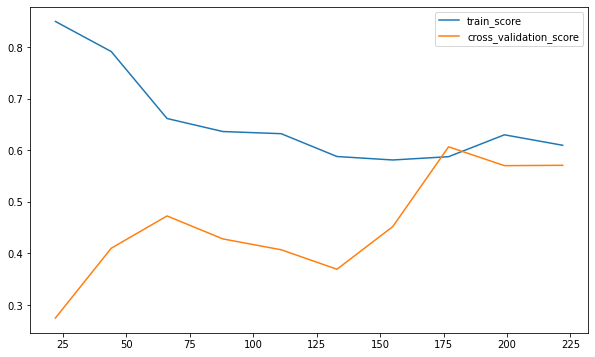

In [37]:
evaluation(model_19, X_train, y_train, X_test, y_test )

[[54  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



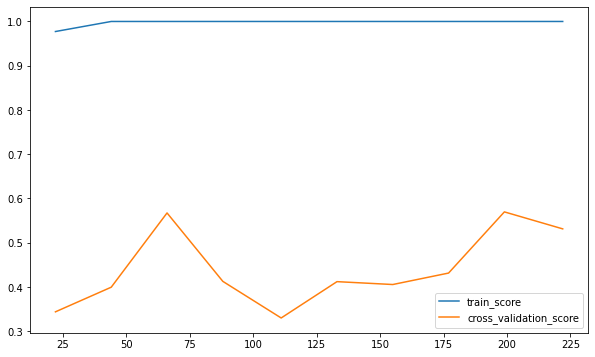

In [38]:
evaluation(model_20, X_train, y_train, X_test, y_test )

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[53  1]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        54
           1       0.75      0.25      0.38        12

    accuracy                           0.85        66
   macro avg       0.80      0.62      0.64        66
weighted avg       0.84      0.85      0.82        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      0.97      0.99        38

    accuracy                           1.00       296
   macro avg       1.00      0.99      0.99       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/p

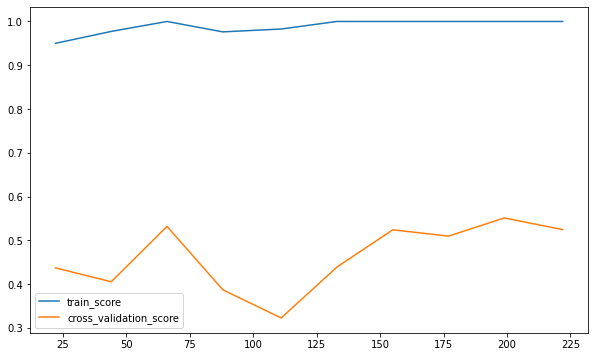

In [39]:
evaluation(model_21, X_train, y_train, X_test, y_test )

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [15 16 18 21 22 23 24 25 26 27 28 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16 18 21 23 24 25 26 29 30 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered

[[52  2]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        54
           1       0.60      0.25      0.35        12

    accuracy                           0.83        66
   macro avg       0.73      0.61      0.63        66
weighted avg       0.81      0.83      0.80        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      0.97      0.99        38

    accuracy                           1.00       296
   macro avg       1.00      0.99      0.99       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [18 23 29 31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/p

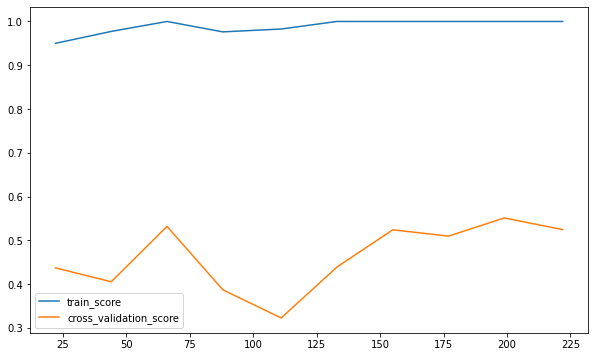

In [40]:
evaluation(model_22, X_train, y_train, X_test, y_test )

In [41]:
# PREMIERE BASE DE DONNEES (data) + SECONDE PREPROCESSING

# train set et test set
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

# Les quatres ensembles (X_train, y_train, X_test, y_test)
X_train, y_train = preprocessing_feature_engineering(train_set)
X_test, y_test = preprocessing_feature_engineering(test_set)


0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

[[86  9]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        95
           1       0.44      0.44      0.44        16

    accuracy                           0.84       111
   macro avg       0.67      0.67      0.67       111
weighted avg       0.84      0.84      0.84       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



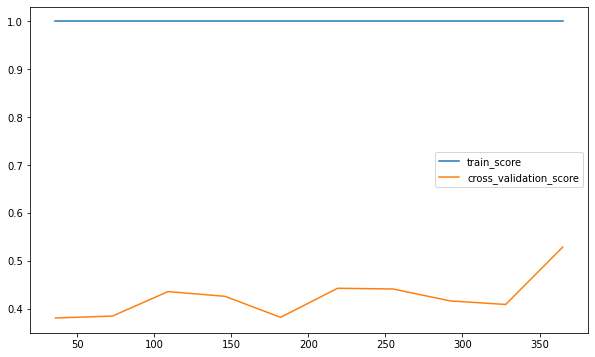

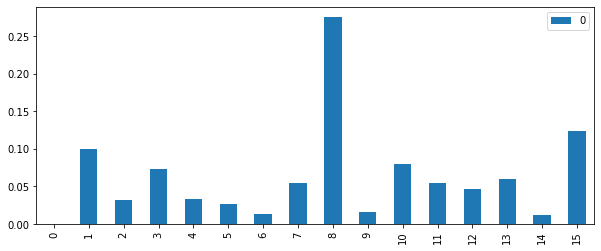

In [42]:
evaluation(model_1, X_train, y_train, X_test, y_test )
pd.DataFrame(model_1.feature_importances_).plot.bar(figsize=(10,4) )

[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



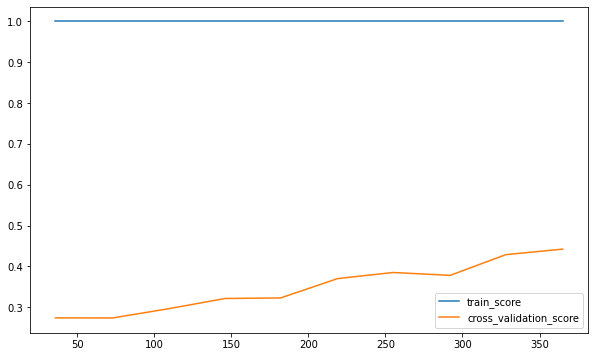

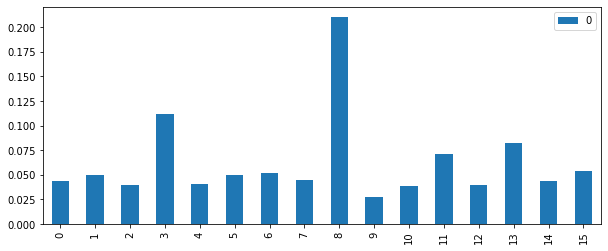

In [43]:
evaluation(model_2, X_train, y_train, X_test, y_test )
pd.DataFrame(model_2.feature_importances_).plot.bar(figsize=(10,4) )

[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



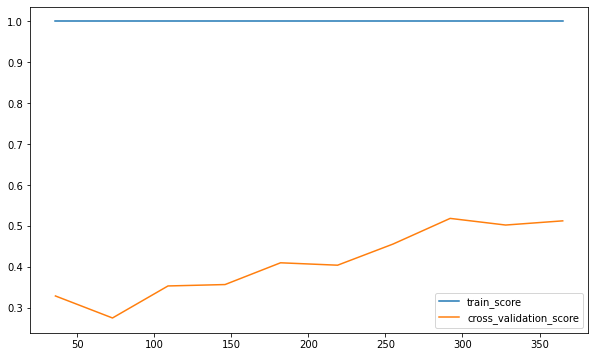

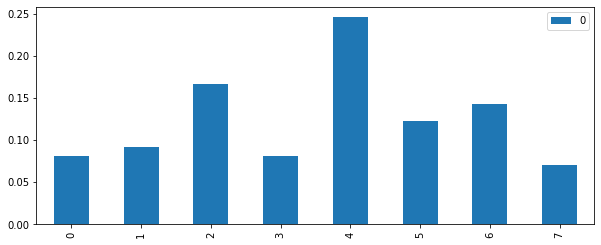

In [44]:
evaluation(model_3, X_train, y_train, X_test, y_test )
pd.DataFrame(model_3[1].feature_importances_).plot.bar(figsize=(10,4) )


[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



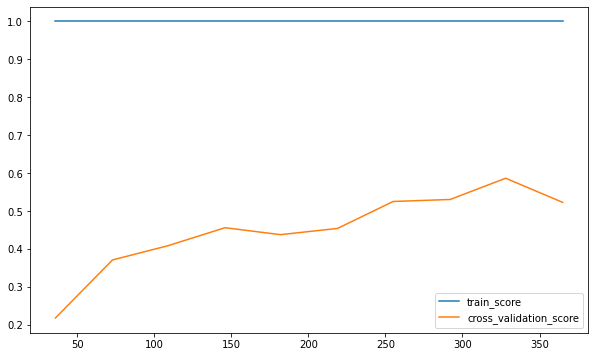

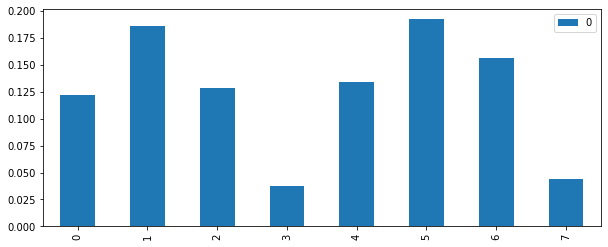

In [45]:
evaluation(model_4, X_train, y_train, X_test, y_test )
pd.DataFrame(model_4[2].feature_importances_).plot.bar(figsize=(10,4) )

[[88  7]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      0.98      0.99        65

    accuracy                           1.00       487
   macro avg       1.00      0.99      1.00       487
weighted avg       1.00      1.00      1.00       487



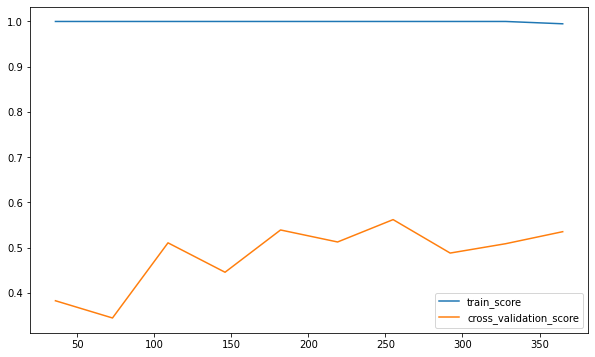

In [46]:
evaluation(model_5, X_train, y_train, X_test, y_test )

[[90  5]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        95
           1       0.58      0.44      0.50        16

    accuracy                           0.87       111
   macro avg       0.75      0.69      0.71       111
weighted avg       0.86      0.87      0.87       111

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       422
           1       0.91      0.80      0.85        65

    accuracy                           0.96       487
   macro avg       0.94      0.89      0.92       487
weighted avg       0.96      0.96      0.96       487



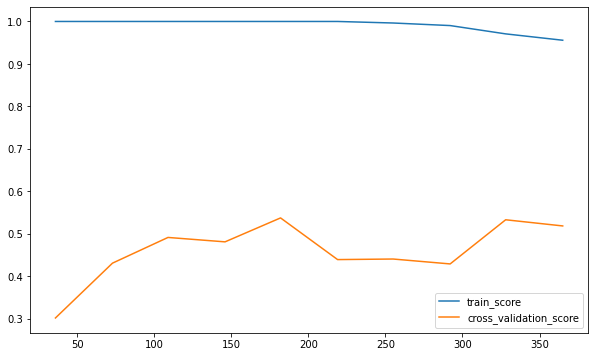

In [47]:
evaluation(model_6, X_train, y_train, X_test, y_test )

[[93  2]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        95
           1       0.75      0.38      0.50        16

    accuracy                           0.89       111
   macro avg       0.83      0.68      0.72       111
weighted avg       0.88      0.89      0.88       111

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       422
           1       1.00      0.94      0.97        65

    accuracy                           0.99       487
   macro avg       1.00      0.97      0.98       487
weighted avg       0.99      0.99      0.99       487



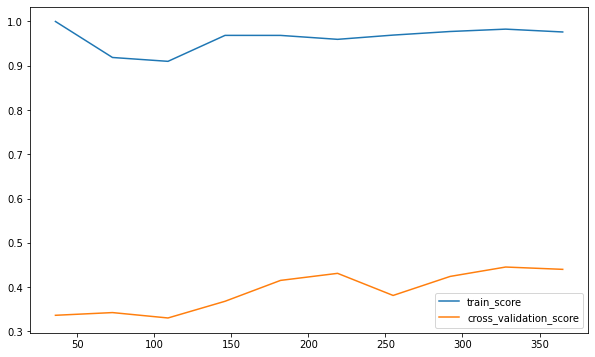

In [48]:
evaluation(model_7, X_train, y_train, X_test, y_test )


[[88  7]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        95
           1       0.50      0.44      0.47        16

    accuracy                           0.86       111
   macro avg       0.70      0.68      0.69       111
weighted avg       0.85      0.86      0.85       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       0.98      0.97      0.98        65

    accuracy                           0.99       487
   macro avg       0.99      0.98      0.99       487
weighted avg       0.99      0.99      0.99       487



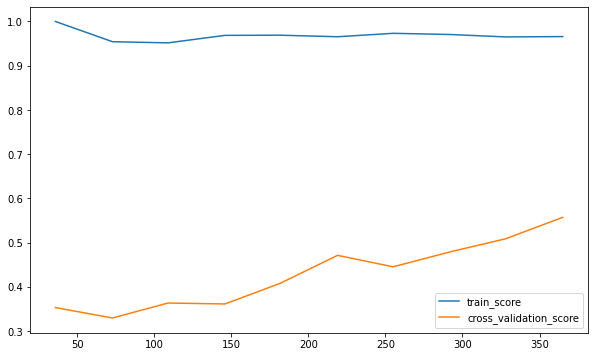

In [49]:
evaluation(model_8, X_train, y_train, X_test, y_test )


[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



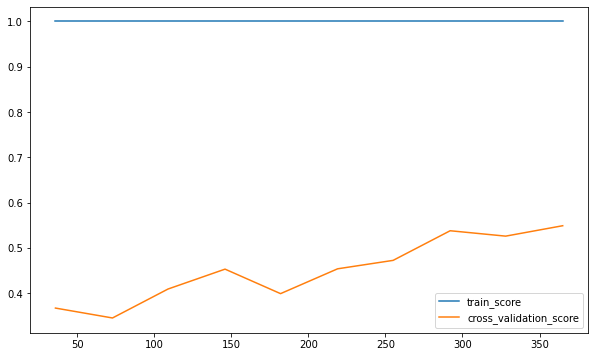

In [50]:
evaluation(model_9, X_train, y_train, X_test, y_test )


[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       0.98      0.92      0.95        65

    accuracy                           0.99       487
   macro avg       0.99      0.96      0.97       487
weighted avg       0.99      0.99      0.99       487



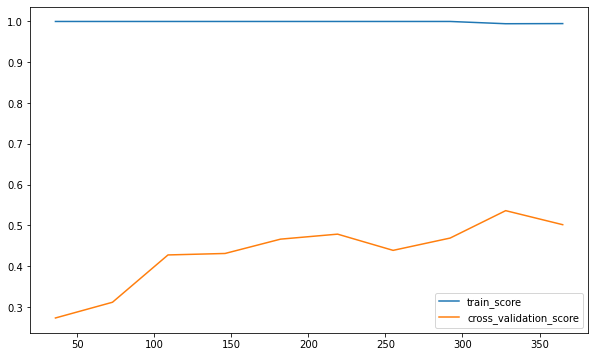

In [51]:
evaluation(model_10, X_train, y_train, X_test, y_test )


[[95  0]
 [16  0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        95
           1       0.00      0.00      0.00        16

    accuracy                           0.86       111
   macro avg       0.43      0.50      0.46       111
weighted avg       0.73      0.86      0.79       111

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       422
           1       0.00      0.00      0.00        65

    accuracy                           0.87       487
   macro avg       0.43      0.50      0.46       487
weighted avg       0.75      0.87      0.80       487



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


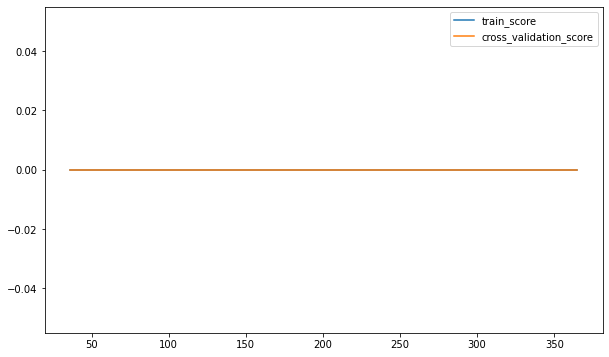

In [52]:
evaluation(model_11, X_train, y_train, X_test, y_test )


[[95  0]
 [16  0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        95
           1       0.00      0.00      0.00        16

    accuracy                           0.86       111
   macro avg       0.43      0.50      0.46       111
weighted avg       0.73      0.86      0.79       111

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       422
           1       0.00      0.00      0.00        65

    accuracy                           0.87       487
   macro avg       0.43      0.50      0.46       487
weighted avg       0.75      0.87      0.80       487



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


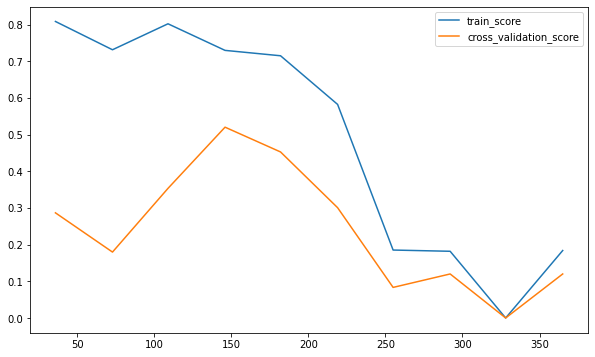

In [53]:
evaluation(model_12, X_train, y_train, X_test, y_test )


[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       422
           1       0.83      0.68      0.75        65

    accuracy                           0.94       487
   macro avg       0.89      0.83      0.86       487
weighted avg       0.94      0.94      0.94       487



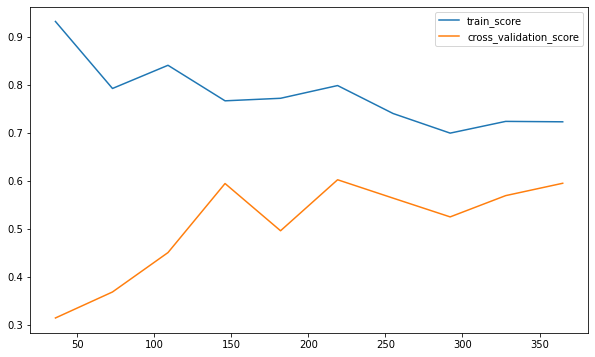

In [54]:
evaluation(model_13, X_train, y_train, X_test, y_test )


[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       422
           1       0.75      0.55      0.64        65

    accuracy                           0.92       487
   macro avg       0.84      0.76      0.79       487
weighted avg       0.91      0.92      0.91       487



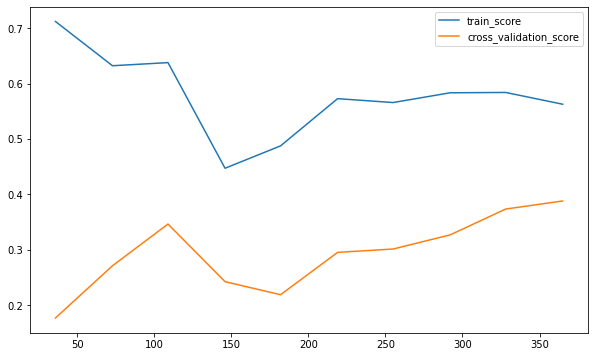

In [55]:
evaluation(model_14, X_train, y_train, X_test, y_test )


[[94  1]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        95
           1       0.75      0.19      0.30        16

    accuracy                           0.87       111
   macro avg       0.81      0.59      0.62       111
weighted avg       0.86      0.87      0.84       111

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       422
           1       0.79      0.57      0.66        65

    accuracy                           0.92       487
   macro avg       0.86      0.77      0.81       487
weighted avg       0.92      0.92      0.92       487



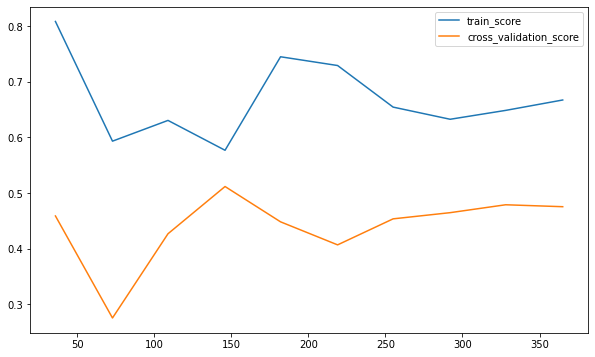

In [56]:
evaluation(model_15, X_train, y_train, X_test, y_test )


[[90  5]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        95
           1       0.62      0.50      0.55        16

    accuracy                           0.88       111
   macro avg       0.77      0.72      0.74       111
weighted avg       0.87      0.88      0.88       111

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       422
           1       0.73      0.68      0.70        65

    accuracy                           0.92       487
   macro avg       0.84      0.82      0.83       487
weighted avg       0.92      0.92      0.92       487



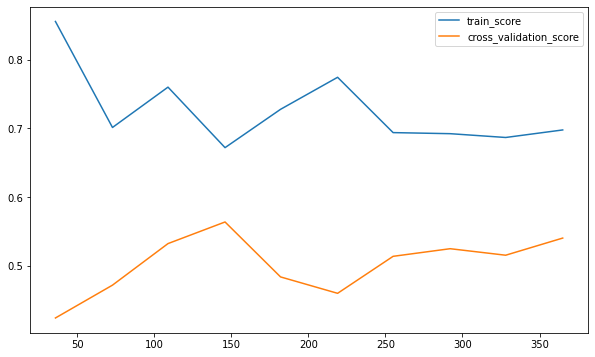

In [57]:
evaluation(model_16, X_train, y_train, X_test, y_test )


[[93  2]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        95
           1       0.71      0.31      0.43        16

    accuracy                           0.88       111
   macro avg       0.80      0.65      0.68       111
weighted avg       0.87      0.88      0.86       111

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       422
           1       0.73      0.51      0.60        65

    accuracy                           0.91       487
   macro avg       0.83      0.74      0.77       487
weighted avg       0.90      0.91      0.90       487



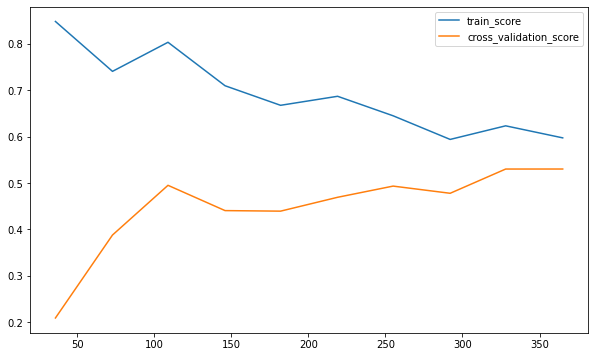

In [58]:
evaluation(model_17, X_train, y_train, X_test, y_test )

[[92  3]
 [12  4]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.57      0.25      0.35        16

    accuracy                           0.86       111
   macro avg       0.73      0.61      0.64       111
weighted avg       0.84      0.86      0.84       111

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       422
           1       0.71      0.46      0.56        65

    accuracy                           0.90       487
   macro avg       0.82      0.72      0.75       487
weighted avg       0.89      0.90      0.89       487



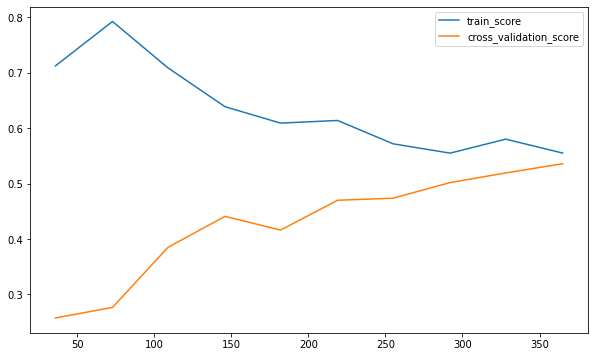

In [59]:
evaluation(model_18, X_train, y_train, X_test, y_test )

[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       422
           1       0.67      0.48      0.56        65

    accuracy                           0.90       487
   macro avg       0.80      0.72      0.75       487
weighted avg       0.89      0.90      0.89       487



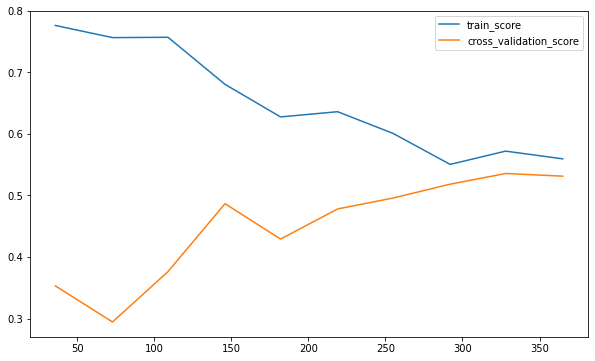

In [60]:
evaluation(model_19, X_train, y_train, X_test, y_test )

[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       0.97      0.95      0.96        65

    accuracy                           0.99       487
   macro avg       0.98      0.97      0.98       487
weighted avg       0.99      0.99      0.99       487



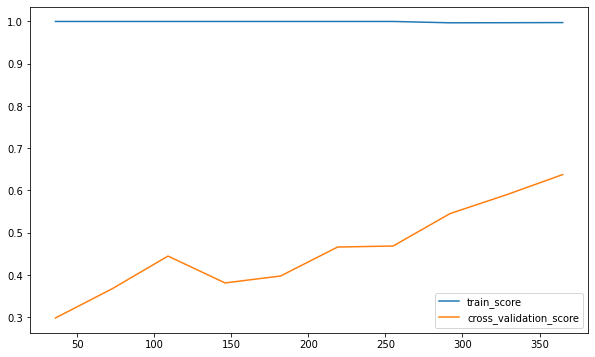

In [61]:
evaluation(model_20, X_train, y_train, X_test, y_test )

[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       422
           1       0.89      0.85      0.87        65

    accuracy                           0.97       487
   macro avg       0.93      0.91      0.92       487
weighted avg       0.96      0.97      0.96       487



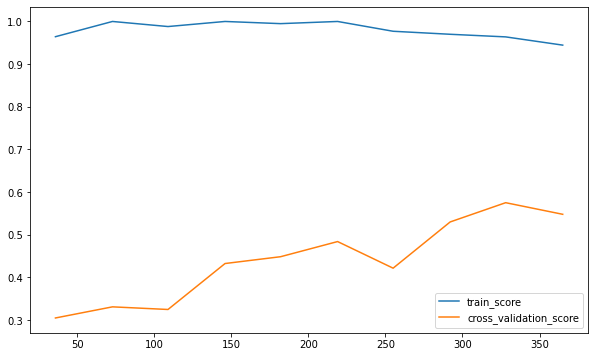

In [62]:
evaluation(model_21, X_train, y_train, X_test, y_test )

[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       422
           1       0.89      0.85      0.87        65

    accuracy                           0.97       487
   macro avg       0.93      0.91      0.92       487
weighted avg       0.96      0.97      0.96       487



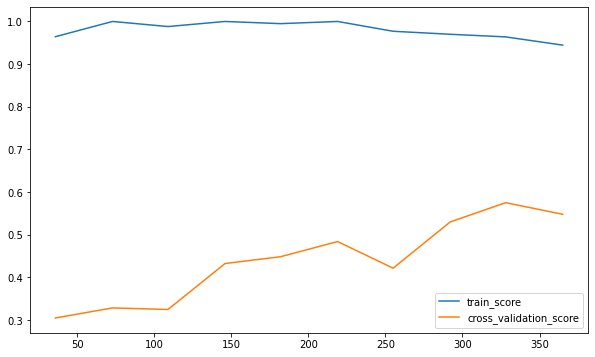

In [63]:
evaluation(model_22, X_train, y_train, X_test, y_test )

In [64]:
# SECONDE BASE DE DONNEES (data_2)
# nouvelle base de données contenant les caractéristiques sanguines
data_2 = data[ key_col + list(sang_col)]

# train set et test set
train_set, test_set = train_test_split(data_2, test_size = 0.2, random_state=0 )

# Les quatres ensembles (X_train, y_train, X_test, y_test)
X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)


0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[[87  8]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        95
           1       0.43      0.38      0.40        16

    accuracy                           0.84       111
   macro avg       0.66      0.65      0.65       111
weighted avg       0.83      0.84      0.83       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



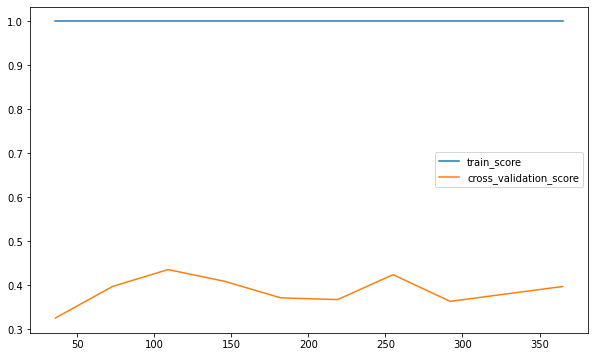

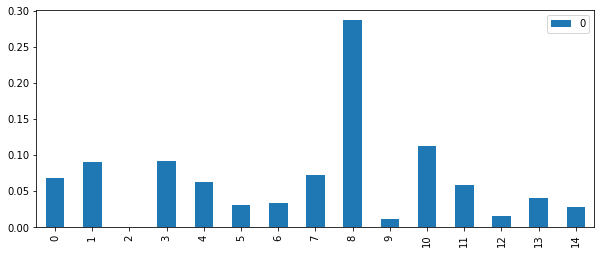

In [65]:
evaluation(model_1, X_train, y_train, X_test, y_test )
pd.DataFrame(model_1.feature_importances_).plot.bar(figsize=(10,4) )


[[94  1]
 [14  2]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        95
           1       0.67      0.12      0.21        16

    accuracy                           0.86       111
   macro avg       0.77      0.56      0.57       111
weighted avg       0.84      0.86      0.82       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



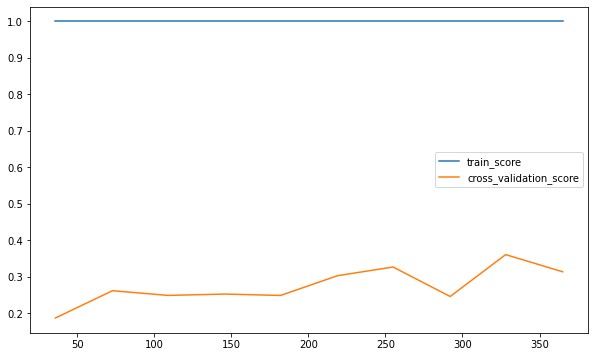

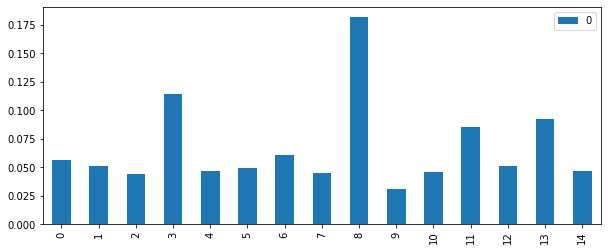

In [66]:
evaluation(model_2, X_train, y_train, X_test, y_test )
pd.DataFrame(model_2.feature_importances_).plot.bar(figsize=(10,4) )

[[94  1]
 [12  4]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        95
           1       0.80      0.25      0.38        16

    accuracy                           0.88       111
   macro avg       0.84      0.62      0.66       111
weighted avg       0.87      0.88      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



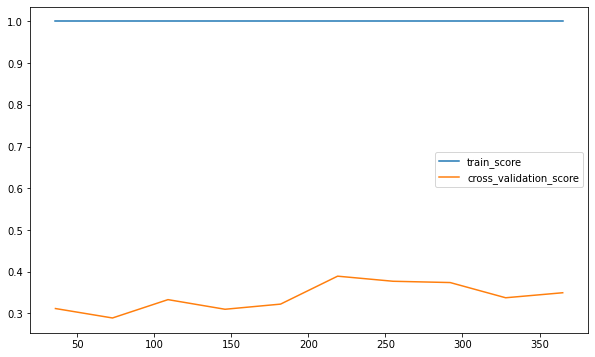

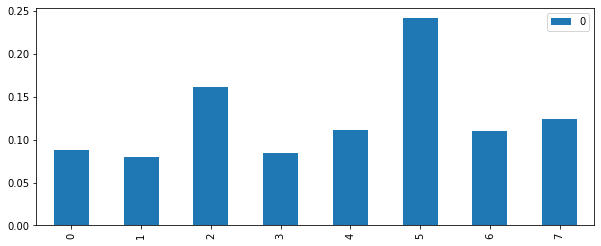

In [67]:
evaluation(model_3, X_train, y_train, X_test, y_test )
pd.DataFrame(model_3[1].feature_importances_).plot.bar(figsize=(10,4) )

[[90  5]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        95
           1       0.50      0.31      0.38        16

    accuracy                           0.86       111
   macro avg       0.70      0.63      0.65       111
weighted avg       0.83      0.86      0.84       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



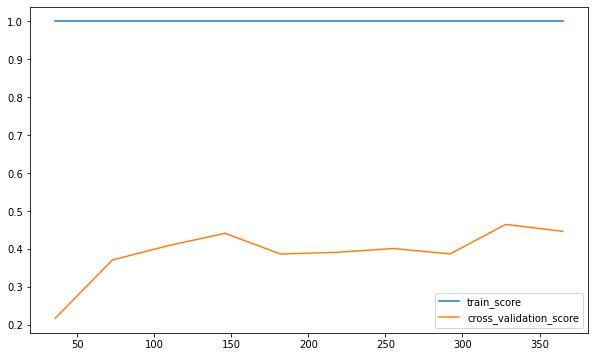

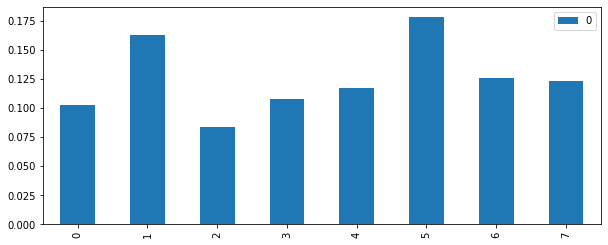

In [68]:
evaluation(model_4, X_train, y_train, X_test, y_test )
pd.DataFrame(model_4[2].feature_importances_).plot.bar(figsize=(10,4) )

[[88  7]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        95
           1       0.42      0.31      0.36        16

    accuracy                           0.84       111
   macro avg       0.65      0.62      0.63       111
weighted avg       0.82      0.84      0.83       111

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       422
           1       0.93      0.86      0.90        65

    accuracy                           0.97       487
   macro avg       0.96      0.93      0.94       487
weighted avg       0.97      0.97      0.97       487



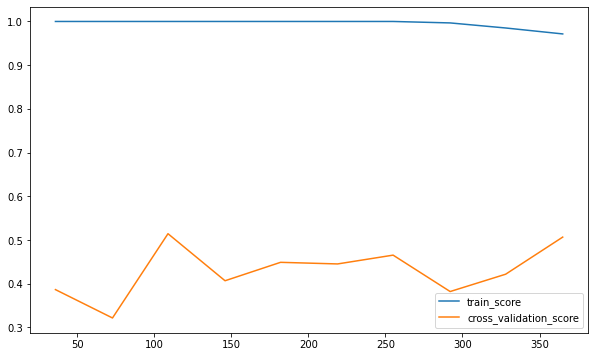

In [69]:
evaluation(model_5, X_train, y_train, X_test, y_test )


[[88  7]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        95
           1       0.46      0.38      0.41        16

    accuracy                           0.85       111
   macro avg       0.68      0.65      0.66       111
weighted avg       0.84      0.85      0.84       111

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       422
           1       0.89      0.83      0.86        65

    accuracy                           0.96       487
   macro avg       0.93      0.91      0.92       487
weighted avg       0.96      0.96      0.96       487



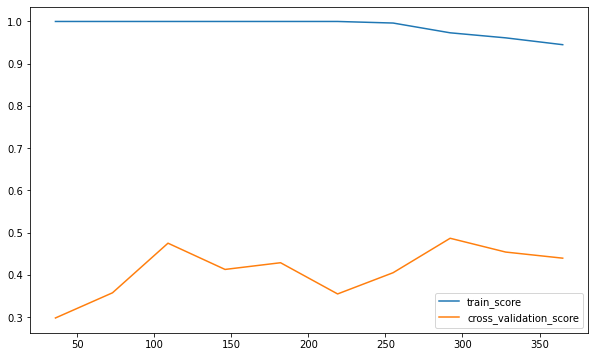

In [70]:
evaluation(model_6, X_train, y_train, X_test, y_test )


[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       1.00      0.91      0.95        65

    accuracy                           0.99       487
   macro avg       0.99      0.95      0.97       487
weighted avg       0.99      0.99      0.99       487



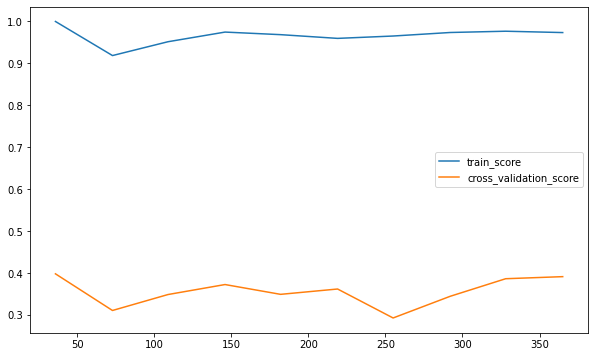

In [71]:
evaluation(model_7, X_train, y_train, X_test, y_test )


[[89  6]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        95
           1       0.54      0.44      0.48        16

    accuracy                           0.86       111
   macro avg       0.72      0.69      0.70       111
weighted avg       0.85      0.86      0.86       111

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       0.98      0.92      0.95        65

    accuracy                           0.99       487
   macro avg       0.99      0.96      0.97       487
weighted avg       0.99      0.99      0.99       487



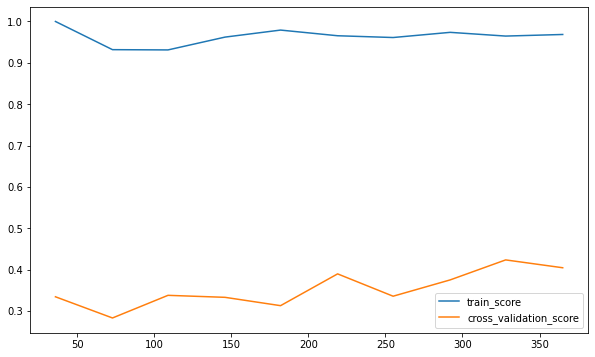

In [72]:
evaluation(model_8, X_train, y_train, X_test, y_test )


[[93  2]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        95
           1       0.75      0.38      0.50        16

    accuracy                           0.89       111
   macro avg       0.83      0.68      0.72       111
weighted avg       0.88      0.89      0.88       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      0.97      0.98        65

    accuracy                           1.00       487
   macro avg       1.00      0.98      0.99       487
weighted avg       1.00      1.00      1.00       487



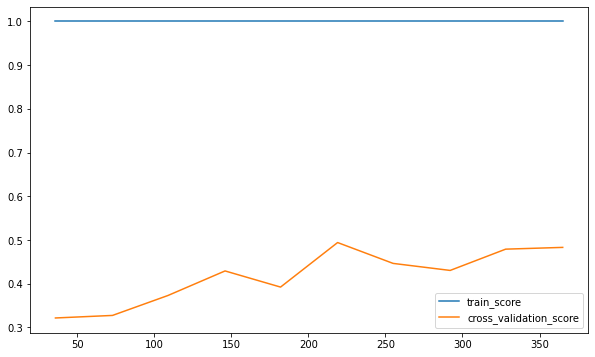

In [73]:
evaluation(model_9, X_train, y_train, X_test, y_test )


[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weighted avg       0.87      0.88      0.87       111

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       0.98      0.91      0.94        65

    accuracy                           0.99       487
   macro avg       0.98      0.95      0.97       487
weighted avg       0.99      0.99      0.99       487



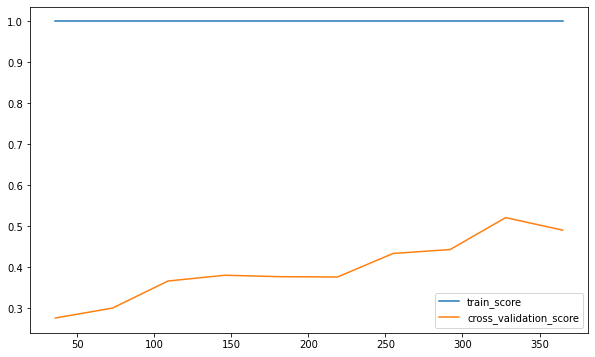

In [74]:
evaluation(model_10, X_train, y_train, X_test, y_test )


[[95  0]
 [16  0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        95
           1       0.00      0.00      0.00        16

    accuracy                           0.86       111
   macro avg       0.43      0.50      0.46       111
weighted avg       0.73      0.86      0.79       111

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       422
           1       0.00      0.00      0.00        65

    accuracy                           0.87       487
   macro avg       0.43      0.50      0.46       487
weighted avg       0.75      0.87      0.80       487



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


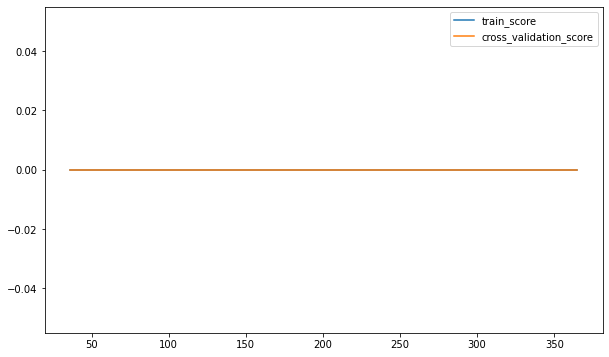

In [75]:
evaluation(model_11, X_train, y_train, X_test, y_test )


[[95  0]
 [16  0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        95
           1       0.00      0.00      0.00        16

    accuracy                           0.86       111
   macro avg       0.43      0.50      0.46       111
weighted avg       0.73      0.86      0.79       111

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       422
           1       0.00      0.00      0.00        65

    accuracy                           0.87       487
   macro avg       0.43      0.50      0.46       487
weighted avg       0.75      0.87      0.80       487



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


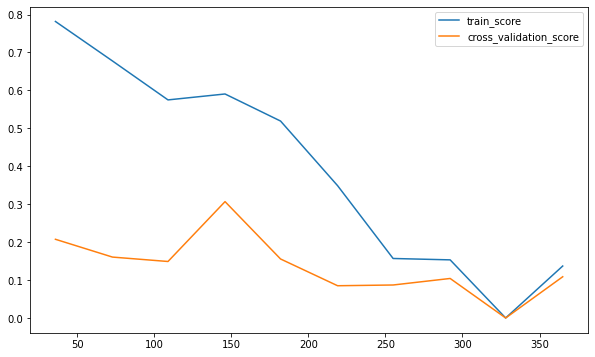

In [76]:
evaluation(model_12, X_train, y_train, X_test, y_test )


[[94  1]
 [12  4]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        95
           1       0.80      0.25      0.38        16

    accuracy                           0.88       111
   macro avg       0.84      0.62      0.66       111
weighted avg       0.87      0.88      0.86       111

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       422
           1       0.80      0.43      0.56        65

    accuracy                           0.91       487
   macro avg       0.86      0.71      0.75       487
weighted avg       0.90      0.91      0.90       487



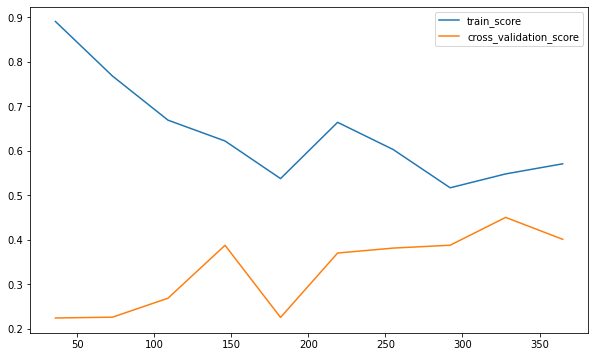

In [77]:
evaluation(model_13, X_train, y_train, X_test, y_test )


[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       422
           1       0.79      0.51      0.62        65

    accuracy                           0.92       487
   macro avg       0.86      0.74      0.78       487
weighted avg       0.91      0.92      0.91       487



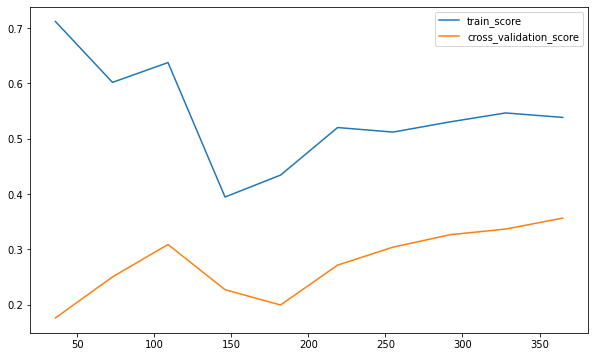

In [78]:
evaluation(model_14, X_train, y_train, X_test, y_test )


[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       422
           1       0.74      0.48      0.58        65

    accuracy                           0.91       487
   macro avg       0.83      0.73      0.76       487
weighted avg       0.90      0.91      0.90       487



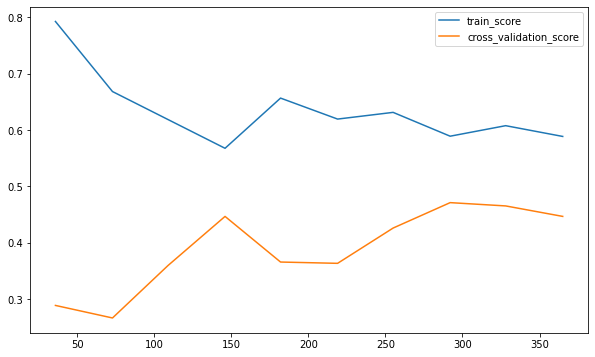

In [79]:
evaluation(model_15, X_train, y_train, X_test, y_test )

[[92  3]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       422
           1       0.75      0.55      0.64        65

    accuracy                           0.92       487
   macro avg       0.84      0.76      0.79       487
weighted avg       0.91      0.92      0.91       487



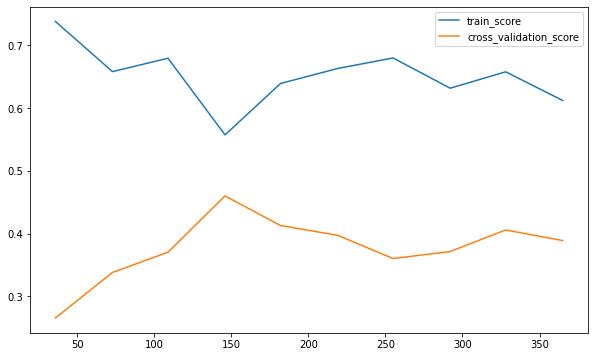

In [80]:
evaluation(model_16, X_train, y_train, X_test, y_test )


[[92  3]
 [14  2]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        95
           1       0.40      0.12      0.19        16

    accuracy                           0.85       111
   macro avg       0.63      0.55      0.55       111
weighted avg       0.80      0.85      0.81       111

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       422
           1       0.68      0.40      0.50        65

    accuracy                           0.90       487
   macro avg       0.80      0.69      0.72       487
weighted avg       0.88      0.90      0.88       487



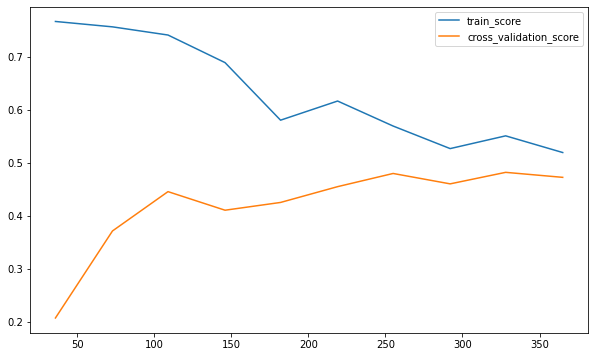

In [81]:
evaluation(model_17, X_train, y_train, X_test, y_test )

[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       422
           1       0.70      0.40      0.51        65

    accuracy                           0.90       487
   macro avg       0.81      0.69      0.73       487
weighted avg       0.89      0.90      0.88       487



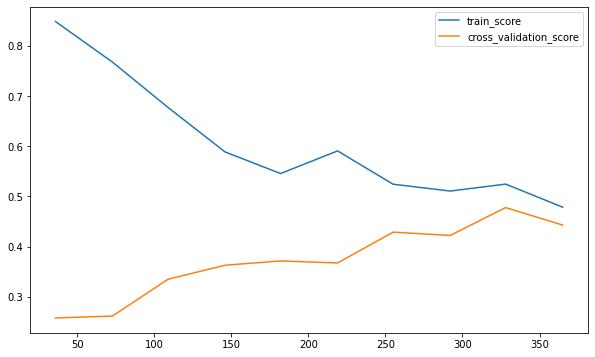

In [82]:
evaluation(model_18, X_train, y_train, X_test, y_test )

[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       422
           1       0.70      0.40      0.51        65

    accuracy                           0.90       487
   macro avg       0.81      0.69      0.73       487
weighted avg       0.89      0.90      0.88       487



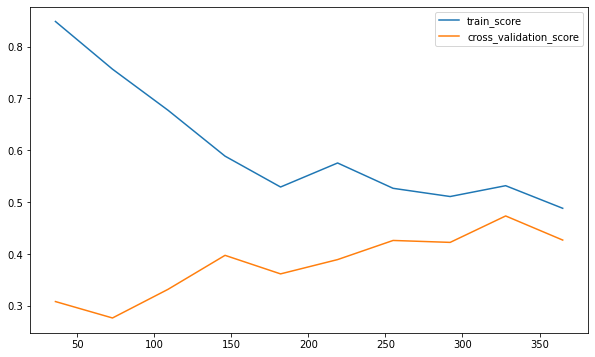

In [83]:
evaluation(model_19, X_train, y_train, X_test, y_test )

[[93  2]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        95
           1       0.75      0.38      0.50        16

    accuracy                           0.89       111
   macro avg       0.83      0.68      0.72       111
weighted avg       0.88      0.89      0.88       111

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       422
           1       0.98      0.92      0.95        65

    accuracy                           0.99       487
   macro avg       0.99      0.96      0.97       487
weighted avg       0.99      0.99      0.99       487



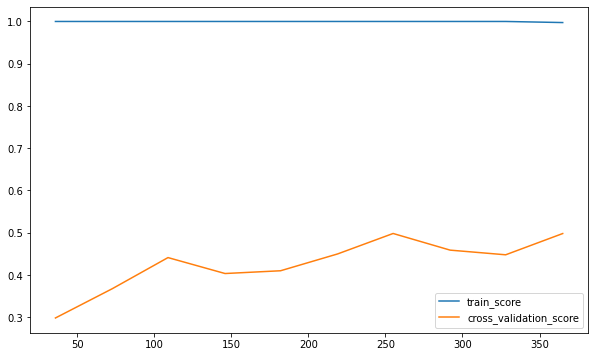

In [84]:
evaluation(model_20, X_train, y_train, X_test, y_test )

[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       422
           1       0.97      0.86      0.91        65

    accuracy                           0.98       487
   macro avg       0.97      0.93      0.95       487
weighted avg       0.98      0.98      0.98       487



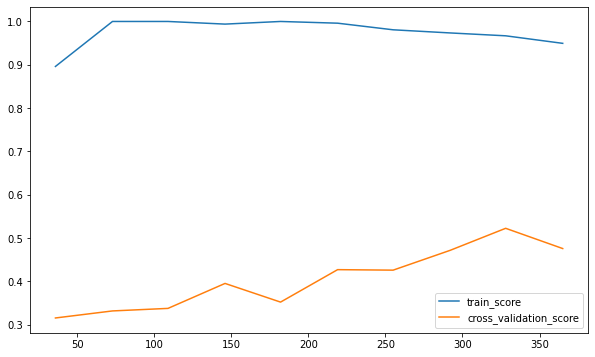

In [85]:
evaluation(model_21, X_train, y_train, X_test, y_test )

[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       422
           1       0.97      0.86      0.91        65

    accuracy                           0.98       487
   macro avg       0.97      0.93      0.95       487
weighted avg       0.98      0.98      0.98       487



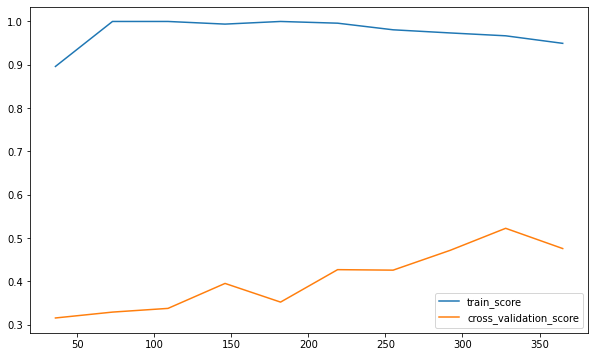

In [86]:
evaluation(model_22, X_train, y_train, X_test, y_test )